# 预测房价
### Step 1：数据准备

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape

(404, 13)

In [2]:
# 数据标准化

mean = train_data.mean(axis=0)
train_data -=mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Step 2：构建网络并训练

In [3]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K折验证

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = [] 

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

all_scores

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


[1.8770711421966553, 2.446460247039795, 2.3184731006622314, 2.373448371887207]

In [7]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('precessing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
all_mae_histories

precessing fold # 0
precessing fold # 1
precessing fold # 2
precessing fold # 3


[[3.5076451301574707,
  2.6864354610443115,
  2.6281604766845703,
  2.7026166915893555,
  2.4487853050231934,
  2.370419979095459,
  2.32769775390625,
  2.297447919845581,
  2.339576005935669,
  2.06034517288208,
  2.4439809322357178,
  2.46733021736145,
  2.330862045288086,
  2.0626425743103027,
  2.019456624984741,
  2.0188510417938232,
  2.1376793384552,
  2.0607900619506836,
  2.2389309406280518,
  2.0732991695404053,
  2.222672939300537,
  2.221966028213501,
  1.9877849817276,
  1.963300347328186,
  1.9509727954864502,
  1.888757348060608,
  1.8860644102096558,
  1.8003506660461426,
  1.874696135520935,
  1.9634109735488892,
  1.8934884071350098,
  1.7678823471069336,
  1.9056073427200317,
  1.8594846725463867,
  2.1039233207702637,
  1.7593433856964111,
  1.7271630764007568,
  1.958235502243042,
  2.229114532470703,
  1.9532240629196167,
  2.1353108882904053,
  1.7750766277313232,
  2.1226911544799805,
  1.8949494361877441,
  2.0884850025177,
  1.9286417961120605,
  1.95101511478

In [8]:
# 计算所有伦次中的K折验证分数平均值

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs) ]

### Step 3：绘制图像
**绘制验证分数**

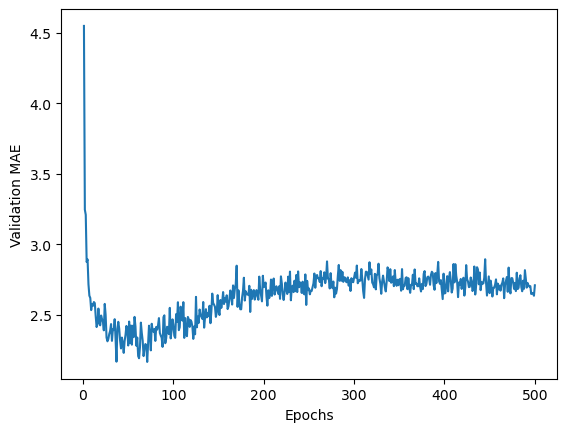

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

**绘制验证分数（删除前10个点）**

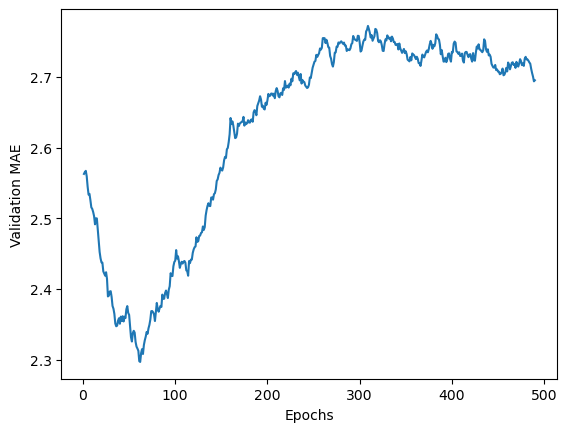

In [10]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Step 4：训练最终模型

In [17]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=71, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 16.6293 - mae: 2.5731


2.5730578899383545